In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import pandas as pd
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import nltk
import spacy
import sys
from spacy.lang.en import English
import en_core_web_sm
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
df = pd.read_json("/content/drive/My Drive/Colab Notebooks/Topic Modelling/Sarcasm_Headlines_Dataset.json", lines=True)
df = df[['headline', 'is_sarcastic']]
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
# Data processing steps:

#Check for missing values in headline, is_sarcastic
#Convert all words into lowercase
#Check for imbalanced classes in dataset
#Removal of punctuation

In [6]:
df['headline'] = df.headline.apply(lambda x:x.lower())  # convert all words in headline into lower case 
df['headline'] = df.headline.apply(lambda x: ' '.join(word.strip(string.punctuation) for word in x.split()))  # remove all punctuations in headline


In [7]:
df['headline_count'] = df.headline.apply(lambda x: len(list(x.split())))
df['headline_unique_word_count'] = df.headline.apply(lambda x: len(set(x.split())))
df['headline_has_digits'] = df.headline.apply(lambda x: bool(re.search(r'\d', x)))
df

,headline,is_sarcastic,headline_count,headline_unique_word_count,headline_has_digits
0,former versace store clerk sues over secret bl...,0,12,12,False
1,the roseanne revival catches up to our thorny ...,0,14,14,False
2,mom starting to fear son's web series closest ...,1,14,13,False
3,boehner just wants wife to listen not come up ...,1,13,13,False
4,j.k rowling wishes snape happy birthday in the...,0,11,11,False
...,...,...,...,...,...
26704,american politics in moral free-fall,0,5,5,False
26705,america's best 20 hikes,0,4,4,True
26706,reparations and obama,0,3,3,False
26707,israeli ban targeting boycott supporters raise...,0,8,8,False


In [8]:
nlp = en_core_web_sm.load()
parser = English()
en_stop = set(nltk.corpus.stopwords.words('english'))


def tokenize(text):
    """this function is to tokenize the headline into a list of individual words"""
    lda_tokens = []
    tokens = parser(text)  # need to use parser for python to treat the list as words
    for token in tokens:
        if token.orth_.isspace():  # to ignore any whitespaces in the headline, so that token list does not contain whitespaces 
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)   # tokens (headlines) are already in lowercase
    return lda_tokens


def get_lemma(word):
    """this function is to lemmatize the words in a headline into its root form"""
    lemma = wn.morphy(word)  # converts the word into root form from wordnet
    if lemma is None:
        return word
    else:
        return lemma
    

def prepare_text_for_lda(text):
    tokens = tokenize(text)  # parse and tokenize the headline into a list of words
    tokens = [token for token in tokens if len(token) > 4]  # remove headlines with only length of 4 words or less
    tokens = [token for token in tokens if token not in en_stop]  # remove stopwords in the headline
    tokens = [get_lemma(token) for token in tokens]  # lemmatize the words in the headline
    return tokens

In [9]:
text_data = []
for headline in df.headline:
    tokens = prepare_text_for_lda(headline)
    text_data.append(tokens)
    
text_data

[['former',
  'versace',
  'store',
  'clerk',
  'secret',
  'black',
  'minority',
  'shopper'],
 ['roseanne', 'revival', 'catch', 'thorny', 'political', 'better', 'worse'],
 ['starting', 'series', 'close', 'thing', 'grandchild'],
 ['boehner', 'want', 'listen', 'alternative', 'reduction', 'idea'],
 ['rowling', 'wish', 'snape', 'happy', 'birthday', 'magical'],
 ['advance', 'world', 'woman'],
 ['fascinate', 'eating', 'grow'],
 ['school', 'company'],
 ['snake', 'handler', 'leaf', 'sinking', 'huckabee', 'campaign'],
 ['friday', 'morning', 'email', 'inside', 'trump', 'presser'],
 ['airline', 'passenger', 'tackle', 'rush', 'cockpit', 'threat'],
 ['facebook', 'reportedly', 'working', 'healthcare', 'feature'],
 ['north', 'korea', 'praise', 'trump', 'urge', 'voter', 'reject', 'hillary'],
 ['actually', 'jeffrey', 'indefensible'],
 ['barcelona', 'hold', 'protest', 'support', 'refugee'],
 ['nuclear', 'detonate', 'rehearsal', 'spider', 'musical'],
 ['cosby', 'lawyer', 'accuser', 'forward', 'smear'

In [10]:
from gensim import corpora
import pickle

dictionary = corpora.Dictionary(text_data)  # Convert all headlines into a corpus of words, with each word as a token
corpus = [dictionary.doc2bow(text) for text in text_data]  # Convert each headline (a list of words) into the bag-of-words format. (Word ID, Count of word)
pickle.dump(corpus, open('corpus.pkl', 'wb'))  
dictionary.save('dictionary.gensim')  # takes a while to run the dictionary and corpus


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [11]:
dictionary

In [12]:
corpus

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)],
 [(15, 1), (16, 1), (17, 1), (18, 1), (19, 1)],
 [(20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)],
 [(26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)],
 [(32, 1), (33, 1), (34, 1)],
 [(35, 1), (36, 1), (37, 1)],
 [(38, 1), (39, 1)],
 [(40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1)],
 [(46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1)],
 [(52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)],
 [(58, 1), (59, 1), (60, 1), (61, 1), (62, 1)],
 [(51, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1)],
 [(70, 1), (71, 1), (72, 1)],
 [(73, 1), (74, 1), (75, 1), (76, 1), (77, 1)],
 [(78, 1), (79, 1), (80, 1), (81, 1), (82, 1)],
 [(83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1)],
 [(90, 1), (91, 1), (92, 1), (93, 1), (94, 1)],
 [(8, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1)],
 [(100, 1), (101, 1), (102, 1)],
 [(

In [13]:
import gensim

# passes: Number of passes through the corpus during training
# alpha: priori on the distribution of the topics in each document.
# The higher the alpha, the higher the likelihood that document contains a wide range of topics, vice versa. 
# beta: priori on the distribution of the words in each topic.
# The higher the beta, the higher the likelihood that topic contains a wide range of words, vice versa.
# we do not alter / fine tune the default values of alpha and beta

# Trying to create with 10 topics as of now
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=5)
topics

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[(0,
  '0.012*"break" + 0.010*"child" + 0.009*"report" + 0.008*"pretty" + 0.008*"learn"'),
 (1,
  '0.017*"watch" + 0.011*"student" + 0.009*"attack" + 0.009*"school" + 0.009*"police"'),
 (2,
  '0.014*"party" + 0.011*"every" + 0.009*"world" + 0.008*"candidate" + 0.008*"sander"'),
 (3,
  '0.017*"change" + 0.015*"school" + 0.010*"health" + 0.010*"release" + 0.010*"climate"'),
 (4,
  '0.015*"family" + 0.010*"friend" + 0.010*"thing" + 0.010*"report" + 0.010*"movie"'),
 (5,
  '0.055*"woman" + 0.025*"house" + 0.021*"white" + 0.010*"right" + 0.008*"report"'),
 (6,
  '0.011*"state" + 0.011*"call" + 0.010*"reason" + 0.009*"business" + 0.009*"obama"'),
 (7,
  '0.096*"trump" + 0.028*"donald" + 0.011*"nation" + 0.010*"would" + 0.010*"things"'),
 (8,
  '0.015*"study" + 0.013*"court" + 0.012*"find" + 0.009*"fight" + 0.009*"local"'),
 (9,
  '0.020*"clinton" + 0.011*"hillary" + 0.008*"campaign" + 0.007*"north" + 0.006*"super"')]

In [14]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4878847586553049


In [15]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=dictionary,num_topics=10,random_state=100,chunksize=100,
                                           passes=10,per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=text_data, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [16]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
# alpha: priori on the distribution of the topics in each document.
# The higher the alpha, the higher the likelihood that document contains a wide range of topics, vice versa. 

#alpha = list(np.arange(0.01, 1, 0.3))
#alpha.append('symmetric')
#alpha.append('asymmetric')

# Beta parameter
# beta: priori on the distribution of the words in each topic.
# The higher the beta, the higher the likelihood that topic contains a wide range of words, vice versa.

#beta = list(np.arange(0.01, 1, 0.3))
#beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)

model_results = {'Topics': [],'Coherence': []}

if 1 == 1:
    pbar = tqdm.tqdm(total=5)
    

    # iterate through number of topics
    for k in topics_range:
      cv = compute_coherence_values(corpus=corpus, dictionary=dictionary,k=k)
      # Save the model results
      model_results['Topics'].append(k)
      model_results['Coherence'].append(cv)

      pbar.update(1)
pd.DataFrame(model_results)

13it [28:58, 133.47s/it]

,Topics,Coherence
0,2,0.558360
1,3,0.563548
2,4,0.560801
3,5,0.566621
4,6,0.572357
5,7,0.572146
6,8,0.574680
7,9,0.560248
8,10,0.562432
9,11,0.567579


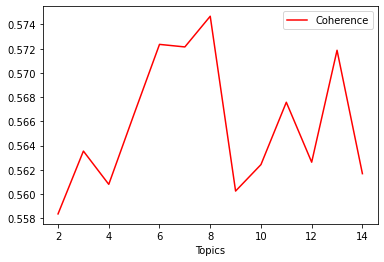

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# a scatter plot comparing num_children and num_pets
pd.DataFrame(model_results).plot(kind='line',x='Topics',y='Coherence',color='red')
plt.show()